# MPS code

In [9]:
%matplotlib inline
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.linalg import svd
import matplotlib as mpl
import time
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

### Linestyles ###
colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ['brown','green','blue','pink','black']
linewidth = [2,2,3,3,4]
linestyle = ['solid','dashed','dashdot','dotted','solid']

## 1. Hamiltonian in the rotating frame

The system Hamiltonian:

\begin{align}
\hat{H}_S=\hbar\Delta_c\hat{c}^\dagger\hat{c} + \hbar\Delta_e\hat{\sigma}_+\hat{\sigma}_-
            +\hbar g\left(\hat{c}^\dagger\hat{\sigma}_-+\hat{\sigma}_+\hat{c}\right)
            +\frac{\hbar\Omega_c}{2}\left(\hat{c}+\hat{c}^\dagger\right)
            +\frac{\hbar\Omega_e}{2}\left(\hat{\sigma}_-+\hat{\sigma}_+\right)
\end{align}

The interaction with the environment with feedback:

\begin{align}
\hat{H}_{fb}(t)=-i\hbar\left\{\left[\sqrt{\gamma_R}\hat{b}(t-\tau)e^{-i\phi}+\sqrt{\gamma_L}\hat{b}(t)\right]\hat{c}^\dagger-\left[\sqrt{\gamma_R}\hat{b}^\dagger(t-\tau)e^{i\phi}+\sqrt{\gamma_L}\hat{b}^\dagger(t)\right]\hat{c}\right\}
\end{align}

where the feedback phase is
\begin{align}
\phi=\pi-\omega_L\tau
\end{align}

The bath is originally Markovain with
\begin{align}
\left[\hat{b}(t),\hat{b}^\dagger(t^\prime)\right]=\delta(t-t^\prime)
\end{align}


## 2. Time-evolution

\begin{align}
|\Psi(t_{k+1})\rangle=U(t_{k+1},t_k)|\Psi(t_k)\rangle
\end{align}

with $\Psi$ written as a Matrix Product State. The time-evolution operator can be expanded as
\begin{align}
U(t_{k+1},t_k) &= \exp{\left[-\frac{i}{\hbar}\left(H_S\Delta t+\int_{t_k}^{t_{k+1}}H_{fb}(t)dt\right)\right]}\\
{\bf U}&=\exp{\left({\bf M}_S+{\bf M}_B\right)} = \sum_{n=0}^\infty\frac{1}{n!}\left({\bf M}_S+{\bf M}_B\right)^n
\end{align}
where $t_k=k\Delta t$ and $\Delta B(t_k) = \int_{t_k}^{t_{k+1}}b(t)dt$. This means that
\begin{align}
\left[\Delta B(t_k),\Delta B^\dagger(t_j)\right] = \Delta t \delta_{k,j}
\end{align}

Therefore the different orders of the expansion above are:
\begin{align}
{\bf U} &=\mathbb{1}+\color{red}{{\bf M}_B}+\color{orange}{{\bf M}_S+\frac{1}{2}{\bf M}_B^2}+
            \color{green}{\frac{1}{2}\left({\bf M}_S{\bf M}_B+{\bf M}_B{\bf M}_S\right)+\frac{1}{6}{\bf M}_B^3}+
            \color{blue}{\frac{1}{2}{\bf M}_S^2+\frac{1}{6}\left({\bf M}_S{\bf M}_B^2+{\bf M}_B{\bf M}_S{\bf M}_B+{\bf M}_B^2{\bf M}_S\right)+\frac{1}{24}{\bf M}_B^4}+\mathcal{O}(\Delta t^{5/2})
\end{align}
This means that to first order we have:
<img src='U_mat_JCM.png'>

## 3. Test case #1: no feedback
Let us consider a TLS on a waveguide. We need up to 4 photons in the environment and a system vector with size 2. $\gamma_R=0$
<img src='U_mat_TLS.png'>

In [10]:
#index in the init list = timebin index: 0=16, ..., 15=1, 16=0, 17=S, 18=-1, 19=-2, 20=-3
start = time.time()

gamma_L = 1.
Om_TLS  = 1.5*np.pi#*gamma_L
Delta_T = 1.0
dt      = .0001
endt=int(12/dt)+3
init = [0]*endt
l=3
initTLS = np.array([0,1]) #starting at |e>
initenv = np.zeros(2)
initenv[0] = 1
# Initial state of the system
init[endt-4] = initTLS

### This function basically implements the formula above without feedback ###
def U(tk,tS): #tk: time bin state at k, tS: state of S
    U_m      = sc.eye(tk.size,tk.size,1)*np.sqrt(np.arange(0,tk.size)) # decreasing the number of photons in the environment bin with 1
    #print(np.dot(U_m,tk))
    U_p      = sc.eye(tk.size,tk.size,-1)*np.sqrt(np.arange(1,tk.size+1)) # increasing the number of photons in the environment bin with 1
    #print(np.dot(U_p,tk))
    sm       = sc.eye(2,2,1) # sigma_-
    sp       = sc.eye(2,2,-1) # sigma_+
    
    ### Different terms in U ###
    
    #####Identity#####
    T_0      = np.tensordot(tk,tS,0) #identity operation
    
    #####Terms with \delta_{i_Tg}\Delta_{j_Te}#####
    U_tk_ig_je = - 1j*dt*Om_TLS*sc.eye(tk.size,tk.size) + \
                ( -1 + dt*gamma_L/6*np.arange(0,tk.size) + .5j*Delta_T*dt )*np.sqrt(dt*gamma_L)*U_m 
    T_ig_je = np.tensordot(np.dot(U_tk_ig_je,tk),np.dot(sp,tS),0)    
    
    #####Terms with \delta_{i_Te}\Delta_{j_Tg}#####
    U_tk_ie_jg = - 1j*dt*Om_TLS*sc.eye(tk.size,tk.size) + \
                ( 1- dt*gamma_L/6*np.arange(1,tk.size+1) - .5*Delta_T*dt )*np.sqrt(dt*gamma_L)*U_p 
    T_ie_jg = np.tensordot(np.dot(U_tk_ie_jg,tk),np.dot(sm,tS),0)    

    #####Terms with \delta_{i_Te}\Delta_{j_Te}#####
    U_tk_ie_je = -(.5*gamma_L*np.arange(1,tk.size+1) + 1j*Delta_T)*dt*sc.eye(tk.size,tk.size) -\
                1j*Om_TLS/2.*np.sqrt(gamma_L)*dt**1.5*(U_p - U_m)
    T_ie_je = np.tensordot(np.dot(U_tk_ie_je,tk), np.dot(np.array([[0,0],[0,1]]),tS),0)

    #####Terms with \delta_{i_Tg}\Delta_{j_Tg}#####
    U_tk_ig_jg = -(.5*gamma_L*np.arange(0,tk.size))*dt*sc.eye(tk.size,tk.size) +\
                1j*Om_TLS/2.*np.sqrt(gamma_L)*dt**1.5*(U_m - U_p)
    T_ig_jg = np.tensordot(np.dot(U_tk_ig_jg,tk), np.dot(np.array([[1,0],[0,0]]),tS),0)
    
    #nextstep = T_0 + T_sqdt_1 + T_sqdt_2 + T_dt_S_1 + T_dt_S_2 + T_dt_S_3 + T_dt_B_1 + T_dt_B_2    
    nextstep = T_0 + T_ig_je + T_ie_jg + T_ie_je + T_ig_jg
    return(nextstep)

print("initial excitation:",np.einsum("k,k",np.einsum("i,ik",initTLS,np.array([[0,0],[0,1]])),np.conjugate(initTLS)))
print("initial ground probability:",np.einsum("k,k",np.einsum("i,ik",initTLS,np.array([[1,0],[0,0]])),np.conjugate(initTLS)))
m=0
exc2 = np.zeros(endt-3,complex)
norm = np.zeros(endt-3,complex)
norm2 = np.zeros(endt-2,complex)
norm2[endt-3] = np.dot(init[endt-4],np.conjugate(init[endt-4]))
norm3 = np.zeros(endt-2,complex)
norm3[endt-3] = np.dot(init[endt-4],np.conjugate(init[endt-4]))
exc = np.zeros(endt-3,complex)

#IMPORTANT: One needs to be careful with the final indices that come out of the summation of einsum, better to define them.

for m in np.arange(endt-4,-1,-1):
#    print("before\n",init[m].shape)
#    print(init[m])
#    if m<endt-4:
#        print(init[m+1].shape)
#    print(m)

    ### Calculating the norm ###
    if m==endt-4:
        #print(init[m])
        nor11 = np.dot(init[m],np.conjugate(init[m]))
        #print("nor1",nor1)
    elif m==endt-5:
        nor21 = np.einsum("ik,jk->ij",init[m+1],np.conjugate(init[m+1]))
        nor11 = np.einsum("ij,ij",np.einsum("li,lj->ij",init[m],np.conjugate(init[m])),nor21)
    else:
        nor31 = np.einsum("mli,nlj->minj",init[m+1],np.conjugate(init[m+1]))
        nor21 = np.einsum("minj,ij->mn",nor31,nor21)
        #print("nor2=",nor2)
        #print(nor2.shape)
        nor11 = np.einsum("mn,mn",np.einsum("lm,ln->mn",init[m],np.conjugate(init[m])),nor21)
    norm[m] = nor11

    ### Determining the excitation level of the qubit ###
    if m==endt-4:
        exc[m]=np.einsum("k,k",np.einsum("i,ik",init[m],np.array([[1,0],[0,0]])),np.conjugate(init[m]))
        exc2[m]=np.einsum("k,k",np.einsum("i,ik",init[m],np.array([[0,0],[0,1]])),np.conjugate(init[m]))
    else:
#        exc2[m]=np.einsum("jk,kj",np.einsum("ij,ik->jk",init[m],np.array([[0,0],[0,1]])),np.conjugate(init[m]))
        exc2_pre=np.einsum("ik,kj->ij",np.einsum("li,lk->ik",init[m],np.array([[0,0],[0,1]])),np.conjugate(init[m]))
        exc2[m] = np.einsum("ij,ij",exc2_pre,nor21)
        exc_pre=np.einsum("ik,kj->ij",np.einsum("li,lk->ik",init[m],np.array([[1,0],[0,0]])),np.conjugate(init[m]))
        exc[m] = np.einsum("ij,ij",exc_pre,nor21)
#        exc[m]=np.einsum("jk,kj",np.einsum("ij,ik->jk",init[m],np.array([[1,0],[0,0]])),np.conjugate(init[m]))
    
    ### A time-step ###
    # We consider up to 4 excitations in the environmental timebin (first array)
    together = U(initenv,init[m]) #normalized
#    print("together shape\n",together.shape)
    if m==endt-4:
        tog_swap = np.einsum("ij->ji",together)
        tog_svd  = svd(tog_swap,full_matrices=False)
    else:
        tog_swap = np.einsum("ijk->jik",together)
        di = tog_swap[0,:,0].size
        dj = tog_swap[:,0,0].size
        dk = tog_swap[0,0,:].size
#        print("di=",di,", dk=",dk)
        tog_swap_conc = np.zeros((dj,di*dk),dtype=np.complex128)
        for i in range(0,tog_swap[0,:,0].size):
            for k in range(0,tog_swap[0,0,:].size):
                tog_swap_conc[:,i+di*k]=tog_swap[:,i,k]
        tog_svd_conc = svd(tog_swap_conc,full_matrices=False)
        tog_svd = [0.+0*1j]*3
        tog_svd[2] = np.zeros((dj,di,dk),dtype=np.complex128)
        for I in range(0,tog_swap_conc[:,0].size):
            tog_svd[2][:,I%di,int((I-(I%di))/di)]  = tog_svd_conc[0][:,I]
        tog_svd[1] = tog_svd_conc[1]
        tog_svd[0] = tog_svd_conc[0]

    ### Storing the different Matrices of the timebins and system (I'm not convinced that this is necessary) ###
    init[m] = tog_svd[2]
    init[m-1] = np.dot(tog_svd[0],np.diag(tog_svd[1]))

#    print("after\n",init[m].shape)
#    print(init[m-1].shape)
#print(init[-1])

### Plotting to be happy ###
t=np.arange(0,endt-3)*dt*gamma_L
t2=np.arange(0,endt-2)*dt*gamma_L
end = time.time()
timeh = int((end-start)/3600)
timem = int((end-start)/60-timeh*60)
times = int((end-start)-timeh*3600-60*timem)
print("elapsed time: %02d:%02d:%02d" % (timeh,timem,times))


plt.figure(figsize = (12,7))
plt.plot(t,np.flip(np.real(exc),0),lw=2,label="ground",color=colors["green"])
plt.plot(t,np.flip(np.real(exc2),0),lw=2,label="excited",color=colors["blue"])
#plt.plot(t,np.exp(-gamma_L*t),ls="--",lw=4,color=colors["orange"],label="$\exp{(-\gamma_Lt)}$")
#plt.xlim(0,8)
#plt.ylim(-0.01,1.01)
plt.xlabel("$\gamma_Lt$",fontsize=40)
plt.ylabel("$\left<\sigma_+\sigma_-\\right>$",fontsize=40)
plt.legend(fontsize=25,loc="upper right")
plt.grid(True)
plt.figure(2,figsize = (12,7))
plt.plot(t,np.flip(np.real(norm-1),0),lw=2,label="norm",color=colors["purple"])
plt.grid(True)
plt.ylabel("$\left<\psi(t)|\psi(t)\\right>-1$",fontsize=40)
plt.xlabel("$\gamma_Lt$",fontsize=40)
plt.show()


initial excitation: 1
initial ground probability: 0


KeyboardInterrupt: 

C:\Anaconda\envs\py35\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['FreeSerif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


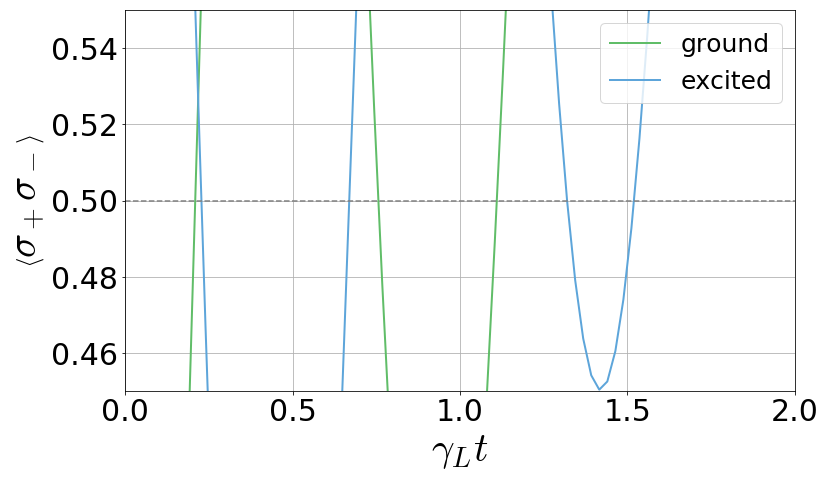

In [9]:
plt.figure(figsize = (12,7))
plt.plot(t,np.flip(np.real(exc),0),lw=2,label="ground",color=colors["green"])
plt.plot(t,np.flip(np.real(exc2),0),lw=2,label="excited",color=colors["blue"])
plt.plot(t,.5+0*t,"--",color="grey")
#plt.plot(t,np.exp(-gamma_L*t),ls="--",lw=4,color=colors["orange"],label="$\exp{(-\gamma_Lt)}$")
plt.xlim(0.0,2)
plt.ylim(0.45,0.55)
plt.xlabel("$\gamma_Lt$",fontsize=40)
plt.ylabel("$\left<\sigma_+\sigma_-\\right>$",fontsize=40)
plt.legend(fontsize=25,loc="upper right")
plt.grid(True)


[1.34926875 0.55821592 0.51096822 0.50646852 0.         0.        ]


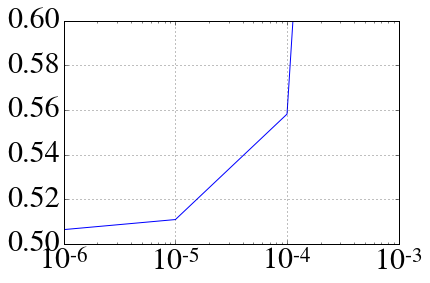

In [123]:
print(spin)
plt.semilogx(delt,spin)
plt.ylim(0.5,0.6)
plt.grid(True)

## 3. Test case #1: no feedback
Let us consider a TLS on a waveguide. We need up to 4 photons in the environment and a system vector with size 2. $\gamma_R=0$
<img src='2nd_order.png'>

In [138]:
#************************************#
#***------------------------------***#
#***| USEFUL BLOCKS AS FUNCTIONS |***#
#***------------------------------***#
#************************************#

############################
### Evolution operator U ###
############################
def U(tk,tS,tl,M): #tk: time bin state at k, tS: state of S
    """Evolution operator up to dt^2 using
    states at the current time (t_k), the delayed time (t_l) and the system state (t_S) at timestep M
    Remember, at M=0 the state is separable"""
    
    print(tk.shape,tS.shape,tl.shape,M)
    
    
    ####--------------------------####
    #### Parameters and operators ####
    ####--------------------------####
    
    #####Dimensions of the physical indices#####
    dim_tk = tk.shape[0]
    if M==0:
        dim_tl = tl.shape[0]
        dim_tS = tS.shape[0]
    else:
        dim_tl = tl.shape[1]
        dim_tS = tS.shape[1]

    #####Frequently used operators#####
        # decreasing the number of photons in the environment bin with 1
    U_m_tk = sc.eye(dim_tk,dim_tk,1)*np.sqrt(dt*gamma_L*np.arange(0,dim_tk)) 
        # increasing the number of photons in the environment bin with 1
    U_p_tk = sc.eye(dim_tk,dim_tk,-1)*np.sqrt(dt*gamma_L*np.arange(1,dim_tk+1)) 
        # decreasing the number of photons in the delayed environment bin with 1
    U_m_tl = np.exp(-1j*phi)*sc.eye(dim_tl,dim_tl,1)*np.sqrt(dt*gamma_R*np.arange(0,dim_tl)) 
        # increasing the number of photons in the delayed environment bin with 1
    U_p_tl = np.exp(1j*phi)*sc.eye(dim_tl,dim_tl,-1)*np.sqrt(dt*gamma_R*np.arange(1,dim_tl+1)) 

    U_2m_tk = np.dot(U_m_tk,U_m_tk)
    U_2m_tl = np.dot(U_m_tl,U_m_tl)
    U_2p_tk = np.dot(U_p_tk,U_p_tk)
    U_2p_tl = np.dot(U_p_tl,U_p_tl)

    U_2np1_tk = (2*np.arange(0,dim_tk)+1)*gamma_L*dt
    U_2np1_tl = (2*np.arange(0,dim_tl)+1)*gamma_R*dt
    U_np_tk = np.arange(0,dim_tk)*gamma_L*dt
    U_np_tl = np.arange(0,dim_tl)*gamma_R*dt

    sm     = sc.eye(2,2,1) # sigma_-
    sp     = sc.eye(2,2,-1) # sigma_+
    
    ####----------------------####
    #### Different terms in U ####
    ####----------------------####
    
    #####Identity#####
    if M == 0:
        T_0      = np.tensordot(np.tensordot(tk,tS,0),tl,0) #identity operation
    else:
        T_0      = np.tensordot(tk,np.einsum("ij,jkl->ikl",tS,tl),0) #identity operation
    
    #####Terms with \delta_{i_Tg}\Delta_{j_Te}#####
    U_ig_je_0 = - 1j*dt*Om_TLS*( 1. -1j*.5*dt*Delta_T) # constant
    U_ig_je_k = ( (-1 + .5j*Delta_T*dt )*U_m_tk +      # only k-dependent
                np.dot(np.diag(U_np_tk),U_m_tk)/6.+
                1j*Om_TLS*dt/6.*np.diag(U_2np1_tk)-
                1j*dt*Om_TLS/6.*U_2m_tk )
    U_ig_je_l = ( (-1 + .5j*Delta_T*dt)*U_m_tl +       # only l-dependent
                np.dot(np.diag(U_np_tl),U_m_tl)/6.+
                1j*Om_TLS*dt/6.*np.diag(U_2np1_tl)-
                1j*dt*Om_TLS/6.*U_2m_tl )
    S_ig_je = np.dot(sp,tS)                            # TLS-state
    if M==0:
        T_ig_je = ( U_ig_je_0*np.tensordot(np.tensordot(tk,S_ig_je,0),tl,0) +                     # constant
                np.tensordot(np.tensordot(np.dot(U_ig_je_k,tk),S_ig_je,0),tl,0) +                 # only k-dependent
                np.tensordot(np.tensordot(tk,S_ig_je,0),np.dot(U_ig_je_l,tl),0) +                 # only l-dependent
                np.tensordot(np.tensordot(np.dot(U_p_tk,tk),S_ig_je,0),np.dot(U_2m_tl,tl),0)/6. + # 3rd order mixed terms
                np.tensordot(np.tensordot(np.dot(U_2m_tk,tk),S_ig_je,0),np.dot(U_p_tl,tl),0)/6.+            
                np.tensordot(np.tensordot(np.dot(U_m_tk,tk),S_ig_je,0),U_2np1_tl*tl,0)/6.+
                np.tensordot(np.tensordot(U_2np1_tk*tk,S_ig_je,0),np.dot(U_m_tl,tl),0)/6.+
                1j*dt*Om_TLS/3.*(np.tensordot(np.tensordot(np.dot(U_m_tk,tk),S_ig_je,0),np.dot(U_p_tl,tl),0)+  
                                 np.tensordot(np.tensordot(np.dot(U_p_tk,tk),S_ig_je,0),np.dot(U_m_tl,tl),0)-
                                 np.tensordot(np.tensordot(np.dot(U_m_tk,tk),S_ig_je,0),np.dot(U_m_tl,tl),0)) )
                                 
    else:
        T_ig_je = ( U_ig_je_0*np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ig_je,tl),0) +                # constant
                np.tensordot(np.dot(U_ig_je_k,tk),np.einsum("ij,jkl->ikl",S_ig_je,tl),0) +            # only k-dependent
                np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ig_je,np.einsum("ij,kjl->kil",U_ig_je_l,tl)),0)+ # only l-dependent
                np.tensordot(np.dot(U_p_tk,tk),                                                  # 3rd order mixed terms
                             np.einsum("ij,jkl->ikl",S_ig_je,np.einsum("ij,kjl->kil",U_2m_tl,tl)),0)/6.+ 
                np.tensordot(np.dot(U_2m_tk,tk),
                             np.einsum("ij,jkl->ikl",S_ig_je,np.einsum("ij,kjl->kil",U_p_tl,tl)),0)/6.+
                np.tensordot(np.dot(U_m_tk,tk),
                             np.einsum("ij,jkl->ikl",S_ig_je,np.einsum("ij,kjl->kil",np.diag(U_2np1_tl),tl)),0)/6.+
                np.tensordot(U_2np1_tk*tk,np.einsum("ij,jkl->ikl",S_ig_je,np.einsum("ij,kjl->kil",U_m_tl,tl)),0)/6.+
                1j*dt*Om_TLS/3.*(np.tensordot(np.dot(U_m_tk,tk),
                                              np.einsum("ij,jkl->ikl",S_ig_je,np.einsum("ij,kjl->kil",U_p_tl,tl)),0)+
                                 np.tensordot(np.dot(U_p_tk,tk),
                                              np.einsum("ij,jkl->ikl",S_ig_je,np.einsum("ij,kjl->kil",U_m_tl,tl)),0)-
                                 np.tensordot(np.dot(U_m_tk,tk),
                                              np.einsum("ij,jkl->ikl",S_ig_je,np.einsum("ij,kjl->kil",U_m_tl,tl)),0)) )
                                 
    U_ig_je_0 = None
    U_ig_je_k = None
    U_ig_je_l = None
    S_ig_je = None
    
    #####Terms with \delta_{i_Te}\Delta_{j_Tg}#####
    U_ie_jg_0 = - 1j*dt*Om_TLS*( 1. -1j*.5*dt*Delta_T) # constant 
    U_ie_jg_k = ( (1. - .5j*Delta_T*dt) * U_p_tk -     # only k-dependent
                np.dot(np.diag(U_np_tk+1),U_p_tk)/6.+
                1j*dt*Om_TLS/6.*np.diag(U_2np1_tk)- 
                1j*dt*Om_TLS/6.*U_2p_tk )
    U_ie_jg_l = ( (1. - .5j*Delta_T*dt)*U_p_tl -       # only l-dependent
                np.dot(np.diag(U_np_tl+1),U_p_tl)/6.+
                1j*dt*Om_TLS/6.*np.diag(U_2np1_tl)-  
                1j*dt*Om_TLS/6.*U_2p_tl )
    S_ie_jg = np.dot(sm,tS)                            # TLS-state
    if M==0:
        T_ie_jg = ( U_ie_jg_0*np.tensordot(np.tensordot(tk,S_ie_jg,0),tl,0) +                    # constant
                np.tensordot(np.tensordot(np.dot(U_ie_jg_k,tk),S_ie_jg,0),tl,0) +                # only k-dependent
                np.tensordot(np.tensordot(tk,S_ie_jg,0),np.dot(U_ie_jg_l,tl),0) +                # only l-dependent
                np.tensordot(np.tensordot(np.dot(U_m_tk,tk),S_ie_jg,0),np.dot(U_2p_tl,tl),0)/6.+ # 3rd order mixed terms
                np.tensordot(np.tensordot(np.dot(U_2p_tk,tk),S_ie_jg,0),np.dot(U_m_tl,tl),0)/6.+
                np.tensordot(np.tensordot(np.dot(U_p_tk,tk),S_ie_jg,0),U_2np1_tl*tl,0)/6.+
                np.tensordot(np.tensordot(U_2np1_tk*tk,S_ie_jg,0),np.dot(U_p_tl,tl),0)/6.+
                1j*dt*Om_TLS/3.*(np.tensordot(np.tensordot(np.dot(U_m_tk,tk),S_ie_jg,0),np.dot(U_p_tl,tl),0)+
                                 np.tensordot(np.tensordot(np.dot(U_p_tk,tk),S_ie_jg,0),np.dot(U_m_tl,tl),0)-
                                 np.tensordot(np.tensordot(np.dot(U_p_tk,tk),S_ie_jg,0),np.dot(U_p_tl,tl),0)) )
    else:
        T_ie_jg = ( U_ie_jg_0*np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ie_jg,tl),0) +                # constant
                np.tensordot(np.dot(U_ie_jg_k,tk),np.einsum("ij,jkl->ikl",S_ie_jg,tl),0) +            # only k-dependent
                np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ie_jg,np.einsum("ij,kjl->kil",U_ie_jg_l,tl)),0)+ # only l-dependent
                np.tensordot(np.dot(U_m_tk,tk),                                                  # 3rd order mixed terms
                             np.einsum("ij,jkl->ikl",S_ie_jg,np.einsum("ij,kjl->kil",U_2p_tl,tl)),0)/6.+ 
                np.tensordot(np.dot(U_2p_tk,tk),np.einsum("ij,jkl->ikl",S_ie_jg,np.einsum("ij,kjl->kil",U_m_tl,tl)),0)/6.+
                np.tensordot(np.dot(U_p_tk,tk),
                             np.einsum("ij,jkl->ikl",S_ie_jg,np.einsum("ij,kjl->kil",np.diag(U_2np1_tl),tl)),0)/6.+
                np.tensordot(U_2np1_tk*tk,np.einsum("ij,jkl->ikl",S_ie_jg,np.einsum("ij,kjl->kil",U_p_tl,tl)),0)/6.+
                1j*dt*Om_TLS/3.*(np.tensordot(np.dot(U_m_tk,tk),
                                              np.einsum("ij,jkl->ikl",S_ie_jg,np.einsum("ij,kjl->kil",U_p_tl,tl)),0)+
                                 np.tensordot(np.dot(U_p_tk,tk),
                                              np.einsum("ij,jkl->ikl",S_ie_jg,np.einsum("ij,kjl->kil",U_m_tl,tl)),0)-
                                 -np.tensordot(np.dot(U_p_tk,tk),
                                               np.einsum("ij,jkl->ikl",S_ie_jg,np.einsum("ij,kjl->kil",U_p_tl,tl)),0)) )
    U_ie_jg_0 = None
    U_ie_jg_k = None
    U_ie_jg_l = None
    S_ie_jg = None
    
    #####Terms with \delta_{i_Te}\Delta_{j_Te}#####
    U_ie_je_0 = -1j*dt*Delta_T-.5*dt**2*(Delta_T**2+Om_TLS**2)                         # constant
    U_ie_je_k = ( np.diag(( -.5 + 1j/3.*Delta_T*dt + 1/24.*(U_np_tk+1) )*(U_np_tk+1))+ # only k-dependent
                .5j*dt*Om_TLS*(U_m_tk-U_p_tk) )
    U_ie_je_l = ( np.diag(( -.5 + 1j/3.*Delta_T*dt + 1/24.*(U_np_tl+1) )*(U_np_tl+1))+ # only l-dependent
                .5j*dt*Om_TLS*(U_m_tl-U_p_tl) )
    S_ie_je = np.dot(np.dot(sp,sm),tS)                                                 # TLS-state
    if M==0:
        T_ie_je = ( U_ie_je_0*np.tensordot(np.tensordot(tk,S_ie_je,0),tl,0) +           # constant
                np.tensordot(np.tensordot(np.dot(U_ie_je_k,tk),S_ie_je,0),tl,0) +       # only k-dependent
                np.tensordot(np.tensordot(tk,S_ie_je,0),np.dot(U_ie_je_l,tl),0) +       # only l-dependent
                (-.5+1j*dt/3.*Delta_T)*                                                 # up to 3rd order mixed terms
                np.tensordot(np.tensordot(np.dot(U_p_tk,tk),S_ie_je,0),np.dot(U_m_tl,tl),0) +
                (-.5+1j*dt/3.*Delta_T)*
                np.tensordot(np.tensordot(np.dot(U_m_tk,tk),S_ie_je,0),np.dot(U_p_tl,tl),0) +
                np.tensordot(np.tensordot(np.dot(np.dot(np.diag(U_2np1_tk),U_m_tk),tk), # 4th order mixed terms
                                          S_ie_je,0),np.dot(U_p_tl,tl),0)/12.+
                np.tensordot(np.tensordot(np.dot(np.dot(np.diag(U_2np1_tk),U_p_tk),tk),S_ie_je,0),
                             np.dot(U_m_tl,tl),0)/12.+
                np.tensordot(np.tensordot(U_2np1_tk*tk,S_ie_je,0),(U_np_tl+1)*tl,0)/12.+
                np.tensordot(np.tensordot((U_np_tk+1)*tk,S_ie_je,0),U_2np1_tl*tl,0)/12.+
                np.tensordot(np.tensordot(np.dot(U_2m_tk,tk),S_ie_je,0),np.dot(U_2p_tl,tl),0)/12.+
                np.tensordot(np.tensordot(np.dot(U_2p_tk,tk),S_ie_je,0),np.dot(U_2m_tl,tl),0)/12.+
                np.tensordot(np.tensordot(np.dot(U_m_tk,tk),S_ie_je,0),
                             np.dot(np.dot(np.diag(U_2np1_tl),U_p_tl),tl),0)/12.+
                np.tensordot(np.tensordot(np.dot(U_p_tk,tk),S_ie_je,0),
                             np.dot(np.dot(np.diag(U_2np1_tl),U_m_tl),tl),0)/12. )
    else:
        T_ie_je = ( U_ie_je_0*np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ie_je,tl),0) +                  # constant
                np.tensordot(np.dot(U_ie_je_k,tk),np.einsum("ij,jkl->ikl",S_ie_je,tl),0) +              # only l-dependent
                np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",U_ie_je_l,tl)),0) +  # only l-dependent
                (-.5+1j*dt/3.*Delta_T)*np.tensordot(np.dot(U_p_tk,tk),                             # up to 3rd order mixed
                                                    np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",U_m_tl,tl)),0)+
                (-.5+1j*dt/3.*Delta_T)*np.tensordot(np.dot(U_m_tk,tk),
                                                    np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",U_p_tl,tl)),0)+
                np.tensordot(np.dot(np.dot(np.diag(U_2np1_tk),U_m_tk),tk),
                             np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",U_p_tl,tl)),0)/12.+     # 4th order mixed
                np.tensordot(np.dot(np.dot(np.diag(U_2np1_tk),U_p_tk),tk),
                             np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",U_m_tl,tl)),0)/12.+
                np.tensordot(U_2np1_tk*tk,
                             np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",np.diag(U_np_tl+1),tl)),0)/12.+
                np.tensordot((U_np_tk+1)*tk,
                             np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",np.diag(U_2np1_tl),tl)),0)/12.+
                np.tensordot(np.dot(U_2m_tk,tk),np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",U_2p_tl,tl)),0)/12.+
                np.tensordot(np.dot(U_2p_tk,tk),np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",U_2m_tl,tl)),0)/12.+
                np.tensordot(np.dot(U_m_tk,tk),
                             np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",np.dot(np.diag(U_2np1_tl),
                                                                                  U_p_tl),tl)),0)/12.+
                np.tensordot(np.dot(U_p_tk,tk),
                             np.einsum("ij,jkl->ikl",S_ie_je,np.einsum("ij,kjl->kil",np.dot(np.diag(U_2np1_tl),
                                                                                  U_m_tl),tl)),0)/12. )

    U_ie_je_0 = None
    U_ie_je_k = None
    U_ie_je_l = None
    S_ie_je = None

    #####Terms with \delta_{i_Tg}\Delta_{j_Tg}#####
    U_ig_jg_0 = -.5*dt**2*Om_TLS**2                                            # constant
    U_ig_jg_k = ( np.diag(( -.5 + 1j/6.*Delta_T*dt + 1/24.*U_np_tk )*U_np_tk)+ # only k-dependent
                .5j*dt*Om_TLS*(U_m_tk-U_p_tk) )
    U_ig_jg_l = ( np.diag(( -.5 + 1j/6.*Delta_T*dt + 1/24.*U_np_tl )*U_np_tl)+ # only l-dependent
                .5j*dt*Om_TLS*(U_m_tl-U_p_tl) )
    S_ig_jg = np.dot(np.dot(sm,sp),tS)                                         # TLS-state
    if M==0:
        T_ig_jg = ( U_ig_jg_0*np.tensordot(np.tensordot(tk,S_ig_jg,0),tl,0) +                # constant
                np.tensordot(np.tensordot(np.dot(U_ig_jg_k,tk),S_ig_jg,0),tl,0) +            # only k-dependent
                np.tensordot(np.tensordot(tk,S_ig_jg,0),np.dot(U_ig_jg_l,tl),0) +            # only l-dependent
                (-.5+1j*dt/6.*Delta_T)*                                                      # up to 3rd order mixed
                np.tensordot(np.tensordot(np.dot(U_p_tk,tk),S_ig_jg,0),np.dot(U_m_tl,tl),0)+
                (-.5+1j*dt/6.*Delta_T)*
                np.tensordot(np.tensordot(np.dot(U_m_tk,tk),S_ig_jg,0),np.dot(U_p_tl,tl),0)+
                np.tensordot(np.tensordot(np.dot(np.dot(np.diag(U_2np1_tk),U_p_tk),tk),      # 4th order mixed
                                          S_ig_jg,0),np.dot(U_m_tl,tl),0)/12.+
                np.tensordot(np.tensordot(np.dot(np.dot(np.diag(U_2np1_tk),U_m_tk),tk),
                                          S_ig_jg,0),np.dot(U_p_tl,tl),0)/12.+
                np.tensordot(np.tensordot(U_2np1_tk*tk,S_ig_jg,0),U_np_tl*tl,0)/12.+
                np.tensordot(np.tensordot(U_np_tk*tk,S_ig_jg,0),U_2np1_tl*tl,0)/12.+
                np.tensordot(np.tensordot(np.dot(U_2m_tk,tk),S_ig_jg,0),np.dot(U_2p_tl,tl),0)/12.+
                np.tensordot(np.tensordot(np.dot(U_2p_tk,tk),S_ig_jg,0),np.dot(U_2m_tl,tl),0)/12.+
                np.tensordot(np.tensordot(np.dot(U_m_tk,tk),S_ig_jg,0),
                             np.dot(np.dot(np.diag(U_2np1_tl),U_p_tl),tl),0)/12.+
                np.tensordot(np.tensordot(np.dot(U_p_tk,tk),S_ig_jg,0),
                             np.dot(np.dot(np.diag(U_2np1_tl),U_m_tl),tl),0)/12. )
    else:
        T_ig_jg = ( U_ig_jg_0*np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ig_jg,tl),0) +                # constant
                np.tensordot(np.dot(U_ig_jg_k,tk),np.einsum("ij,jkl->ikl",S_ig_jg,tl),0) +            # only k-dependent
                np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",U_ig_jg_l,tl)),0)+ # only l-dependent
                (-.5+1j*dt/6.*Delta_T)*                                                          # up to 3rd order mixed
                np.tensordot(np.dot(U_p_tk,tk),np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",U_m_tl,tl)),0)+
                (-.5+1j*dt/6.*Delta_T)*
                np.tensordot(np.dot(U_m_tk,tk),np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",U_p_tl,tl)),0)+
                np.tensordot(np.dot(np.dot(np.diag(U_2np1_tk),U_p_tk),tk),                       # 4th order mixed
                             np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",U_m_tl,tl)),0)/12.+
                np.tensordot(np.dot(np.dot(np.diag(U_2np1_tk),U_m_tk),tk),
                             np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",U_p_tl,tl)),0)/12.+
                np.tensordot(U_2np1_tk*tk,np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",np.diag(U_np_tl),tl)),0)/12.+
                np.tensordot(U_np_tk*tk,np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",np.diag(U_2np1_tl),tl)),0)/12.+
                np.tensordot(np.dot(U_2m_tk,tk),np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",U_2p_tl,tl)),0)/12.+
                np.tensordot(np.dot(U_2p_tk,tk),np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",U_2m_tl,tl)),0)/12.+
                np.tensordot(np.dot(U_m_tk,tk),
                             np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",np.dot(np.diag(U_2np1_tl),
                                                                                  U_p_tl),tl)),0)/12.+
                np.tensordot(np.dot(U_p_tk,tk),
                             np.einsum("ij,jkl->ikl",S_ig_jg,np.einsum("ij,kjl->kil",np.dot(np.diag(U_2np1_tl),
                                                                                  U_m_tl),tl)),0)/12. )

    U_ig_jg_0 = None
    U_ig_jg_k = None
    U_ig_jg_l = None
    S_ig_jg = None
    
    ####--------------####
    #### Obtained MPS ####
    ####--------------####
    
    nextstep = T_0 + T_ig_je + T_ie_jg + T_ie_je + T_ig_jg
    
    return nextstep

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

############################
### Calculating the norm ###
############################
def normf(M,L,state,norm_L):
    """Performing the contractions for the norm using
    the calculated states in list "state" with a delay index-length L 
    and the stored values of norm_L (tensor with indices for state and dual) at timestep M"""
    
    # Indices of the timebins: 0->furthest past, L->system, L+1->first future timebin
    if M==0:
        print(state[L])
        norm = np.einsum("i,i",state[L],np.conjugate(state[L]))
    else:
        # Contracting part of the MPS that won't change anymore with its dual and with previously stored tensors
        if M==1:
            print("state[0]",state[0])
            norm_L = np.einsum("ik,jk->ij",state[0],np.conjugate(state[0]))
        else:
            norm_L = np.einsum("ijkl,kl->ij",np.einsum("imk,jml->ijkl",state[M-1],np.conjugate(state[M-1])),norm_L)
        print("norm_L",norm_L)
        
        # Contracting the system part of the MPS
        norm_S = np.einsum("ki,kj->ij",state[L+M],np.conjugate(state[L+M]))
        print("norm_S",norm_S)
        norm = norm_L
        # Performing the rest of the reservoir contractions from right to left.
        for i in range(0,L):
            norm_past = np.einsum("imk,jml->ijkl",state[M+i],np.conjugate(state[M+i]))
            norm = np.einsum("ijkl,kl->ij",norm_past,norm)
        # Contracting the environment part with the system part
        norm = np.einsum("ij,ij",norm,norm_S)
    print("norm",norm)
    return norm,norm_L

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

#######################
### Merging indices ###
#######################
def merge(block,where):
    """Merging indices to provide a lower-rank tensor from block
    where defines which side of the tensor should the indices be merged"""
    
    ### Determining the rank of the tensor and the index-dimensions
    num_ind = len(block.shape)
    d1 = block.shape[0]
    d2 = block.shape[1]
    d3 = block.shape[2]
    if num_ind==3:
        if where=="left":
            merged_block = np.zeros((d1*d2,d3),dtype=np.complex128)
            for i in range(0,d1):
                for j in range(0,d2):
                    merged_block[i+d1*j,:]=block[i,j,:]
            # passing on the merged dimensions
            dims = np.array([d1,d2])
        elif where=="right":
            merged_block = np.zeros((d1,d2*d3),dtype=np.complex128)
            for i in range(0,d2):
                for j in range(0,d3):
                    merged_block[:,i+d2*j]=block[:,i,j]
            # passing on the merged dimensions
            dims = np.array([d2,d3])
    elif num_ind==4:
        d4 = block.shape[3]
        if where=="left":
            merged_block = np.zeros((d1*d2,d3,d4),dtype=np.complex128)
            for i in range(0,d1):
                for j in range(0,d2):
                    merged_block[i+d1*j,:,:]=block[i,j,:,:]
            # passing on the merged dimensions
            dims = np.array([d1,d2])
        elif where=="right":
            merged_block = np.zeros((d1,d2,d3*d4),dtype=np.complex128)
            for i in range(0,d3):
                for j in range(0,d4):
                    merged_block[:,:,i+d3*j]=block[:,:,i,j]
            # passing on the merged dimensions
            dims = np.array([d3,d4])
        elif where=="both":
            # 2 consequent merges are needed           
            merged_block_1 = np.zeros((d1,d2,d3*d4),dtype=np.complex128)
            for i1 in range(0,d3):
                for j1 in range(0,d4):
                    merged_block_1[:,:,i1+d3*j1]=block[:,:,i1,j1]
            merged_block = np.zeros((d1*d2,d3*d4),dtype=np.complex128)
            for i2 in range(0,d1):
                for j2 in range(0,d2):
                    merged_block[i2+d1*j2,:]=merged_block_1[i2,j2,:]
            merged_block_1=None
            # passing on the merged dimensions
            dims = np.array([d1,d2,d3,d4])
    return merged_block, dims

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

###################################
### Undo the merging of indices ###
###################################
def unmerge(block,dims,where):
    """Unmerging indices to provide a higher-rank tensor from block
    where defines which side of the tensor should the merge of indices be reversed
    and dims stores the achievable index-dimensions"""
    
    D1 = block.shape[0]
    D2 = block.shape[1]
    unmerged_block = np.zeros(dims,dtype=np.complex128)
    if where=="left":
        d1 = dims[0]
        for I in range(0,D1):
            unmerged_block[I%d1,int((I-(I%d1))/d1),:]  = block[I,:]
    elif where=="right":
        d2 = dims[1]
        for I in range(0,D2):
            unmerged_block[:,I%d2,int((I-(I%d2))/d2)]  = block[:,I]
    return unmerged_block

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

##########################################
### Relocating the orthognality centre ###
##########################################
def OC_reloc(state_left,state_right,where):
    """Relocating the orthogonality centre from either of the states
    to the direction specified in "where"."""
    
    # Number of indices for each state besides the link index between them
    left_ind = len(state_left.shape)-1
    right_ind = len(state_right.shape)-1
    # Tensor after the contraction at the link index between the states
    Combo = np.tensordot(state_left,state_right,1)
    # Number of indices left after contraction
    num_ind = left_ind+right_ind
    if num_ind==3:
        if left_ind ==2:
            # Merging the indices on the left to be able to perform svd
            Combo_merged,merge_dims = merge(Combo,"left")
            Combo_merged_svd = svd(Combo_merged,full_matrices=False)
            # number of singular values that matter
            bond_length = np.min(np.array(Combo_merged.shape))
            Combo_merged=None
            # Dimensions of the indices after the OC relocation and unmerge of indices
            dims = np.concatenate((merge_dims,np.array([bond_length])),axis=0)
            if where=="left":
                # OC relocation to the left
                new_left_merged = np.dot(Combo_merged_svd[0],np.diag(Combo_merged_svd[1]))
                new_left = unmerge(new_left_merged,dims,"left")
                new_left_merged=None
                new_right = Combo_merged_svd[2]
                Combo_merged_svd=None
            elif where=="right":
                # OC relocation to the right
                new_right = np.dot(np.diag(Combo_merged_svd[1]),Combo_merged_svd[2])
                new_left = unmerge(Combo_merged_svd[0],dims,"left")
                Combo_merged_svd=None
        elif left_ind ==1:
            # Merging the indices on the right to be able to perform svd
            Combo_merged,dims = merge(Combo,"right")
            Combo_merged_svd = svd(Combo_merged,full_matrices=False)
            # number of singular values
            bond_length = np.min(np.array(Combo_merged.shape))
            Combo_merged=None
            # Dimensions of the indices after the OC relocation and unmerge of indices
            dims = np.concatenate((np.array([bond_length]),merge_dims),axis=0)
            if where=="left":
                # OC relocation to the left
                new_left = np.dot(Combo_merged_svd[0],np.diag(Combo_merged_svd[1]))
                new_right = unmerge(Combo_merged_svd[2],dims,"right")
                Combo_merged_svd=None
            elif where=="right":
                # OC relocation to the right
                new_right_merged = np.dot(np.diag(Combo_merged_svd[1]),Combo_merged_svd[2])
                new_right = unmerge(new_right_merged,dims,"right")
                new_right_merged=None
                new_left = Combo_merged_svd[0]            
                Combo_merged_svd=None
    elif num_ind==4:
        # Merging the indices on both sides to be able to perform svd
        Combo_merged,merge_dims = merge(Combo,"both")
        Combo_merged_svd = svd(Combo_merged,full_matrices=False)
        # number of singular values
        bond_length = np.min(np.array(Combo_merged.shape))
        Combo_merged=None
        # Dimensions of the indices on the left after the OC relocation and unmerge of indices
        dims_left = np.array([merge_dims[0],merge_dims[1],bond_length])
        # Dimensions of the indices on the right after the OC relocation and unmerge of indices
        dims_right = np.array([bond_length,merge_dims[2],merge_dims[3]])
        if where=="left":
            # OC relocation to the left
            new_left_merged = np.dot(Combo_merged_svd[0],np.diag(Combo_merged_svd[1]))
            # unmerging the indices on the left
            new_left = unmerge(new_left_merged,dims_left,"left")
            new_left_merged=None
            # unmerging the indices on the right
            new_right = unmerge(Combo_merged_svd[2],dims_right,"right")
        elif where=="right":
            # OC relocation to the right
            new_right_merged = np.dot(np.diag(Combo_merged_svd[1]),Combo_merged_svd[2])
            # unmerging the indices on the right
            new_right = unmerge(new_right_merged,dims_right,"right")
            new_right_merged=None
            # unmerging the indices on the left
            new_left = unmerge(Combo_merged_svd[0],dims_left,"left")
        Combo_merged_svd=None
    return new_left,new_right

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

####################################
### Separate two physical blocks ###
####################################
def cut(block,how,OC=None):
    """cutting up a block to different time bins with link index locations specified by the argument how
    and the final position of the orthogonality centre can be given as an optional argument"""
    
    # merging the link indices into the physical indices
    block_merged, dims = merge(block,how)
    # separate the block
    block_merged_svd = svd(block_merged,full_matrices=False)
    block_merged=None
    # specifying the link dimension
    link_dim = block_merged_svd[1].size
    if how=="left":
        # specifying the final indices of the left block
        left_dims = np.concatenate((dims,np.array([link_dim])),axis=0)
        # unmerging the link index
        new_left = unmerge(block_merged_svd[0],left_dims,"left")
        # position the orthogonality centre to the right
        new_right = np.einsum("ij,jk->ik",np.diag(block_merged_svd[1]),block_merged_svd[2])
    elif how=="right":
        # specifying the final indices of the right block
        right_dims = np.concatenate((np.array([link_dim]),dims),axis=0)
        new_left = block_merged_svd[0]
        # position the orthogonality centre to the right and unmerging the link index
        new_right = unmerge(np.einsum("ij,jk->ik",np.diag(block_merged_svd[1]),block_merged_svd[2]),right_dims,"right")
    elif how=="both":
        # specifying the final indices of the blocks
        left_dims = np.concatenate((dims[:2],np.array([link_dim])),axis=0)
        right_dims = np.concatenate((np.array([link_dim]),dims[2:]),axis=0)
        if OC=="left":
            # positioning the orthognality centre to the left
            new_right = unmerge(block_merged_svd[2],right_dims,"right")
            new_left = unmerge(np.einsum("jk,kl->jl",block_merged_svd[0],np.diag(block_merged_svd[1])),left_dims,"left")
        elif OC=="right":
            # positioning the orthognality centre to the right
            new_right = unmerge(np.einsum("ij,jk->ik",np.diag(block_merged_svd[1]),block_merged_svd[2]),right_dims,"right")
            new_left = unmerge(block_merged_svd[0],left_dims,"left")
        elif OC== None:
            print("Please specify where is the orthogonality centre after operation with the keywords 'left' or 'right'")
    left_dims = None
    right_dims = None
    block_merged_svd = None
    return new_left,new_right
        

In [139]:
help(U)
help(normf)
help(merge)
help(unmerge)
help(OC_reloc)
help(cut)

Help on function U in module __main__:

U(tk, tS, tl, M)
    Evolution operator up to dt^2 using
    states at the current time (t_k), the delayed time (t_l) and the system state (t_S) at timestep M
    Remember, at M=0 the state is separable

Help on function normf in module __main__:

normf(M, L, state, norm_L)
    Performing the contractions for the norm using
    the calculated states in list "state" with a delay index-length L 
    and the stored values of norm_L (tensor with indices for state and dual) at timestep M

Help on function merge in module __main__:

merge(block, where)
    Merging indices to provide a lower-rank tensor from block
    where defines which side of the tensor should the indices be merged

Help on function unmerge in module __main__:

unmerge(block, dims, where)
    Unmerging indices to provide a higher-rank tensor from block
    where defines which side of the tensor should the merge of indices be reversed
    and dims stores the achievable index-dimension

In [140]:
#**************#
#***--------***#
#***| CODE |***#
#***--------***#
#**************#

############################
### Evolution operator U ###
############################

start = time.time()

gamma_L = 1.
gamma_R = 1.
Om_TLS  = 0.#1.5*np.pi
Delta_T = 0.#1.0
phi     = 0.

endt = 12.
dt   = .1
L    = 3
N    = int(endt/dt)+L

initTLS    = np.array([0,1],complex) #starting at |e>
initenv    = np.zeros(5,complex)
initenv[0] = 1
init       = [initenv]*N
# Initial state of the system
init[L]    = initTLS

norm = np.zeros(N,complex)
print(norm[0])
normL = np.zeros((initenv.size,initenv.size),complex)

for M in range(0,N):
    
    print("M =",M)
    #print(normf(0,L,init,normL))
    norm[M],normL = normf(M,L,init,normL)
    print("norm done")
    print("sys?",init[L+M])
    U_block = U(init[L+1+M],init[L+M],init[L-1+M],M)
    if M > 0:
        U_block,U_right_dims = merge(U_block,"right")
    U_block  = np.einsum("ijk->jik",U_block)
    init[L+1+M],U_small_block = cut(U_block,"right")
    init[L+M],init[L+M-1] = cut(U_small_block,"left")
    print("init[3]",init[3].shape)

    if M > 0:
        U_dims = np.concatenate((np.array([init[L+M-1].shape[0]]),U_right_dims),axis = 0)
        init[L+M-1] = unmerge(init[L+M-1],U_dims,"right")
    print("U done")
    
    for s in range(0,L-1):
        if M==0:
            swap_block = np.tensordot(init[L-1-s],init[L-2-s],0)
            init[L-1-s],init[L-2-s] = cut(np.einsum("ijk->ikj",swap_block),"left")
        else:
            swap_block = np.einsum("ijk,klm->ijlm",init[L+M-1-s],init[L+M-2-s])
            init[L+M-s-1],init[L+M-2-s] = cut(swap_block,"both","right")
    print("swaps done")
    
    init[M+1],init[M] = OC_reloc(init[M+1],init[M],"left")
    print("OC relocation done")
    
    

0j
M = 0
[ 0.+0.j  1.+0.j]
norm (1+0j)
norm done
sys? [ 0.+0.j  1.+0.j]
(5,) (2,) (5,) 0
init[3] (2, 5, 5)
U done
swaps done
OC relocation done
M = 1
state[0] [[-1.+0.j -0.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]]
norm_L [[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
norm_S [[ 1.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j]]
norm (0.148888888889+0j)
norm done
sys? [[ 1.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j]]
(5,) (2, 2) (2, 5, 5) 1
init[3] (10, 25)
U done
swaps done
OC relocation done
M = 2
norm_L [[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+

MemoryError: 

In [ ]:
a= np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]])
svd(a,full_matrices=False)